### This notebook is for exploring the feature 'buildingqualitytypeid', which is definied in the kaggle data dictionary as Overall assessment of condition of the building from best (lowest) to worst (highest).  It is missing a large number of values but I wanted to investigate if it made sense to use and if so can we impute those values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
import explore
import evaluate

from acquire import get_zillow_data
from wrangle import wrangle_zillow
from wrangle import scale_zillow
from splitter import splitter

import warnings
warnings.filterwarnings("ignore")

Load dataset, and use same prep as in the other workbook.

In [2]:
df = get_zillow_data()

In [3]:
df['fireplaces'] = df.fireplaces.fillna(value=0)
df['pools'] = df.pools.fillna(value=0)
df['garages'] = df.garages.fillna(value=0)

In [4]:
df = df[df['bathrooms'] > 0]
df = df[df['bedrooms'] > 0]
df = df[df['bathrooms'] < 7]
df = df[df['bedrooms'] < 7]
df = df[df['sqft'] > 400]
df = df[df['sqft'] < 10000]
df = df[df['selling_price'] > 10000]
df = df[df['selling_price'] < 5000000]
df = df[df['fireplaces'] < 4]
df = df[df['garages'] < 5]
df = df[df['lotsize'] < 217800]
df = df[df['lotsize'] > (.5 * df['sqft'])]
df['fips_name'] = np.where(df.fips == 6037, 'Los Angeles', np.where(df.fips == 6059, 'Orange','Ventura') )
df = df.drop(columns = 'fips')

Dropping nulls at this stage leaves us with only those rows that have a quality score.

In [5]:
df = df.dropna()

<AxesSubplot:xlabel='quality', ylabel='Count'>

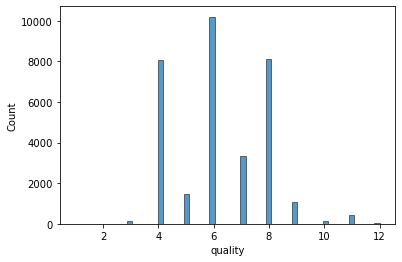

In [6]:
sns.histplot(df, x="quality")

<AxesSubplot:xlabel='fips_name', ylabel='quality'>

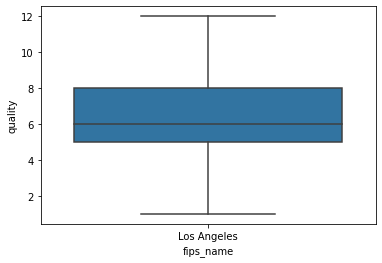

In [7]:
sns.boxplot(data=df, x='fips_name', y='quality')

##### Turns out we only have quality scores for LA county.  Let's proceed to see if within LA this allows for better modeling.

Dropping fips_name as well as other unecessary columns/features.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33047 entries, 3 to 52441
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       33047 non-null  float64
 1   bathrooms      33047 non-null  float64
 2   sqft           33047 non-null  float64
 3   selling_price  33047 non-null  float64
 4   yearbuilt      33047 non-null  float64
 5   quality        33047 non-null  float64
 6   fireplaces     33047 non-null  float64
 7   lotsize        33047 non-null  float64
 8   pools          33047 non-null  float64
 9   garages        33047 non-null  float64
 10  fips_name      33047 non-null  object 
dtypes: float64(10), object(1)
memory usage: 4.0+ MB


In [9]:
df = df.drop(columns = ['fips_name','garages','fireplaces','bathrooms'])

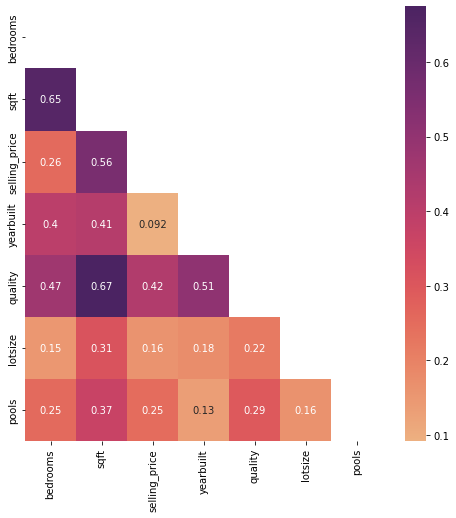

In [10]:
corr = df.corr()

# Pass correlation matrix on to sns heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="flare", mask=np.triu(corr))
plt.show()

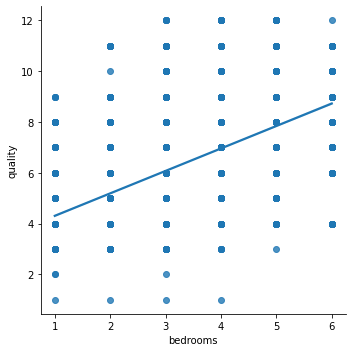

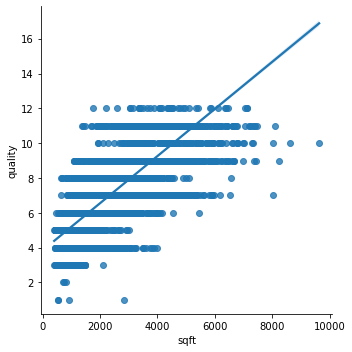

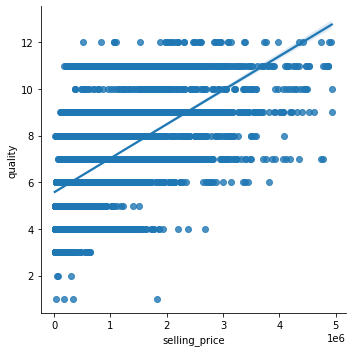

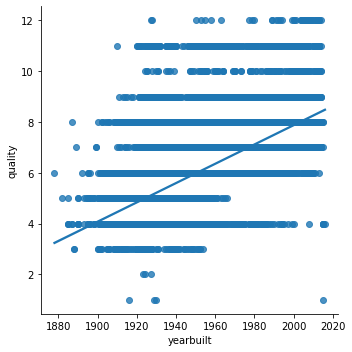

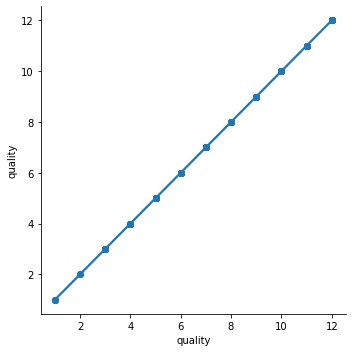

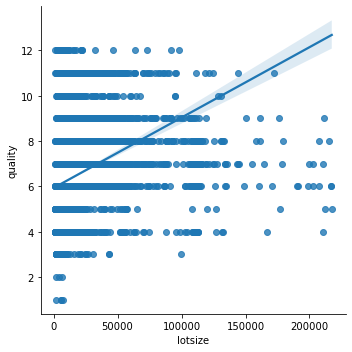

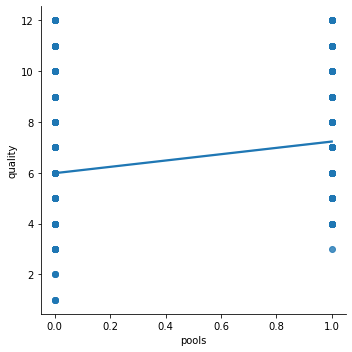

In [11]:
for i in df:
    sns.lmplot(data = df, x=i, y='quality')
    plt.show()

In [12]:
df = df.astype({'bedrooms':'int', 'sqft':'int', 'selling_price':'int', 'yearbuilt':'int','lotsize':'int','pools':'int','quality':'int'})

In [13]:
train, validate, test = splitter(df)
train.head()

Train = 18505 rows (56.0%) | Validate = 7932 rows (24.0%) | Test = 6610 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".


,bedrooms,sqft,selling_price,yearbuilt,quality,lotsize,pools
30653,3,1592,250194,1988,8,4721,0
42260,2,1538,50488,1941,6,7107,0
7300,4,1920,862962,1955,8,11751,1
47339,4,3758,1149392,1953,7,11327,0
43656,2,1366,32874,1920,4,13981,0


In [14]:
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing

def scale_zillow(df_train,df_validate,df_test):
    # Create the object
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(df_train.drop(columns='selling_price'))

    # Fit the data
    df_train_scaled = pd.DataFrame(scaler.transform(df_train.drop(columns=['selling_price'])),columns=df_train.drop(columns=['selling_price']).columns.values).set_index([df_train.index.values])
    df_validate_scaled = pd.DataFrame(scaler.transform(df_validate.drop(columns=['selling_price'])),columns=df_validate.drop(columns=['selling_price']).columns.values).set_index([df_validate.index.values])
    df_test_scaled = pd.DataFrame(scaler.transform(df_test.drop(columns=['selling_price'])),columns=df_test.drop(columns=['selling_price']).columns.values).set_index([df_test.index.values])

    # Add back in the target, selling_price
    df_train_scaled['selling_price'] = df_train['selling_price']
    df_validate_scaled['selling_price'] = df_validate['selling_price']
    df_test_scaled['selling_price'] = df_test['selling_price']

    return df_train_scaled, df_validate_scaled, df_test_scaled

In [15]:
train_scaled, validate_scaled, test_scaled = scale_zillow(train, validate, test)

In [16]:
X_train = train_scaled.drop(columns='selling_price')
y_train = train_scaled.selling_price

X_validate = validate_scaled.drop(columns='selling_price')
y_validate = validate_scaled.selling_price

X_test = test_scaled.drop(columns='selling_price')
y_test = test_scaled.selling_price

In [17]:
for i in range(1,7):
    # parameters: f_regression stats test, give me 8 features
    f_selector = SelectKBest(f_regression, k=i)

    # find the top 8 X's correlated with y
    f_selector.fit(X_train, y_train)

    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()

    # get list of top K features. 
    f_feature = X_train.iloc[:,feature_mask].columns.tolist()
    print(f_feature)

['sqft']
['sqft', 'quality']
['bedrooms', 'sqft', 'quality']
['bedrooms', 'sqft', 'quality', 'pools']
['bedrooms', 'sqft', 'quality', 'lotsize', 'pools']
['bedrooms', 'sqft', 'yearbuilt', 'quality', 'lotsize', 'pools']


In [18]:
for i in range(1,7):
# initialize the ML algorithm
    lm = LinearRegression()

    # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
    rfe = RFE(lm, n_features_to_select=i)

    # fit the data using RFE
    rfe.fit(X_train,y_train)  

    # get the mask of the columns selected
    feature_mask = rfe.support_

    # get list of the column names. 
    rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
    print(rfe_feature)

rfecv = RFECV(lm, min_features_to_select = 1)
rfecv.fit(X_train, y_train)
feature_mask = rfecv.support_
rfecv_feature = X_train.iloc[:,feature_mask].columns.tolist()
print(rfecv_feature)

['sqft']
['sqft', 'yearbuilt']
['sqft', 'yearbuilt', 'quality']
['bedrooms', 'sqft', 'yearbuilt', 'quality']
['bedrooms', 'sqft', 'yearbuilt', 'quality', 'lotsize']
['bedrooms', 'sqft', 'yearbuilt', 'quality', 'lotsize', 'pools']
['bedrooms', 'sqft', 'yearbuilt', 'quality', 'lotsize', 'pools']


In [19]:
X_train_no_qual = train_scaled.drop(columns=['selling_price','quality'])

X_validate_no_qual = validate_scaled.drop(columns=['selling_price','quality'])

X_test_no_qual = test_scaled.drop(columns=['selling_price','quality'])

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [21]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict target_pred_mean
selling_price_pred_mean = y_train['selling_price'].mean()
y_train['selling_price_pred_mean'] = selling_price_pred_mean
y_validate['selling_price_pred_mean'] = selling_price_pred_mean

# 2. compute target_pred_median
selling_price_pred_median = y_train['selling_price'].median()
y_train['selling_price_pred_median'] = selling_price_pred_median
y_validate['selling_price_pred_median'] = selling_price_pred_median

# 3. RMSE of target_pred_mean
rmse_train_mean = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_mean)**(1/2)
rmse_validate_mean = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 5))

# 4. RMSE of target_pred_median
rmse_train_median = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_median)**(1/2)
rmse_validate_median = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_median, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_median, 5))

RMSE using Mean
Train/In-Sample:  501879.65822 
Validate/Out-of-Sample:  461308.90405
RMSE using Median
Train/In-Sample:  520207.64191 
Validate/Out-of-Sample:  477308.13047


### Comparing OLS for Quality vs no quality

#### Quality

In [22]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.selling_price)

# predict train
y_train['selling_price_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm)**(1/2)

# predict validate
y_validate['selling_price_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  397079.12675628107 
Validation/Out-of-Sample:  372749.6808526959


#### No Quality

In [23]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_no_qual, y_train.selling_price)

# predict train
y_train['selling_price_pred_lm'] = lm.predict(X_train_no_qual)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm)**(1/2)

# predict validate
y_validate['selling_price_pred_lm'] = lm.predict(X_validate_no_qual)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  401286.6149747264 
Validation/Out-of-Sample:  376101.50453781406


#### While quality score may be useful without the other features, it does not drastically impove the model when included.  So I feel comfortable dropping it from the analysis data set.